In [1]:
import pandas as pd
import numpy as np

import csv
import json

import re

import itertools

import matplotlib.pyplot as plt
import mpld3

In [7]:
from draftsim_utils_ab import *

Controversial Picks Calculator (by Bobby Mills and Arseny Khakhalin)

In [4]:
#mtgJSON = json.load(open('Allsets.json'))
with open('../../data/Allsets.json', 'r',encoding='utf-8') as json_data:
    mtgJSON = json.load(json_data)

Change the set abbrevation below to work with a different set

In [5]:
#thisSet = mtgJSON['DOM']['cards']
#thisSet = mtgJSON['M19']['cards']
#thisSet = mtgJSON['GRN']['cards']
thisSet = mtgJSON['RNA']['cards']

In [8]:
thisSet = {getName(card) : card for card in thisSet} # a dict with names as indices for cards, for all cards in set

Change the data file below to work with the draftsim data you want

In [9]:
draftData = pd.read_csv('../../2019-01-16 RNA test.csv', 
                       names = ['format', 'human', 'bot1', 'bot2', 'bot3', 'bot4', 'bot5', 'bot6', 'bot7'])
#draftData = pd.read_csv('../2018-10-05 GRN Draft Data 1.csv', 
#                       names = ['format', 'human', 'bot1', 'bot2', 'bot3', 'bot4', 'bot5', 'bot6', 'bot7'])
#draftData = pd.read_csv('05-31-18 Rows 500000-600000.csv', 
#                       names = ['format', 'human', 'bot1', 'bot2', 'bot3', 'bot4', 'bot5', 'bot6', 'bot7'])
#draftData = pd.read_csv('../2018-08-23 m19 drafts round 2.csv', 
#                      names = ['format', 'human', 'bot1', 'bot2', 'bot3', 'bot4', 'bot5', 'bot6', 'bot7'])
#draftData = pd.read_csv('2018-04-16 Dominiaria initial data-2.csv', 
#                        names = ['format', 'human', 'bot1', 'bot2', 'bot3', 'bot4', 'bot5', 'bot6', 'bot7'])
draftData.head()

,format,human,bot1,bot2,bot3,bot4,bot5,bot6,bot7
3024448,RNA,"Chillbringer,Summary_Judgment,Thought_Collapse...","Titanic_Brawl,Titanic_Brawl,Rhythm_of_the_Wild...","Pestilent_Spirit,Scorchmark,Immolation_Shaman,...","Trollbred_Guardian,Arrester's_Admonition,Sauro...","Trollbred_Guardian,Simic_Ascendancy,Applied_Bi...","Ravager_Wurm,Titanic_Brawl,Axebane_Beast,Rampa...","Mortify,Flames_of_the_Raze-Boar,Scorchmark,Und...","Skewer_the_Critics,Incubation_Incongruity,Silh..."
3024449,RNA,"Zegana,_Utopian_Speaker,Theater_of_Horrors,Cry...","Bedeck_Bedazzle,Vindictive_Vampire,Burning-Tre...","Summary_Judgment,Clear_the_Stage,Final_Payment...","Collision_Colossus,Clan_Guildmage,Biogenic_Upg...","Incubation_Incongruity,Gruul_Beastmaster,Sphin...","Trollbred_Guardian,Open_the_Gates,Simic_Guildg...","Electrodominance,Arrester's_Admonition,Goblin_...","Wilderness_Reclamation,Essence_Capture,Lawmage..."
3024450,RNA,"Priest_of_Forgotten_Gods,Imperious_Oligarch,Ba...","Pestilent_Spirit,Titanic_Brawl,Get_the_Point,D...","Electrodominance,Spikewheel_Acrobat,Orzhov_Enf...","Skewer_the_Critics,Grotesque_Demise,Hackrobat,...","Get_the_Point,Arrester's_Admonition,Mortify,Un...","Flames_of_the_Raze-Boar,Gruul_Beastmaster,Biom...","Summary_Judgment,Skewer_the_Critics,Glass_of_t...","Frilled_Mystic,Humongulus,Ministrant_of_Obliga..."
3024451,RNA,"Repudiate_Replicate,Sphinx_of_the_Guildpact,Gy...","Grotesque_Demise,Collision_Colossus,Sauroform_...","Precognitive_Perception,Skitter_Eel,Senate_Gui...","Simic_Ascendancy,Essence_Capture,Spirit_of_the...","Simic_Guildgate_1,Depose_Deploy,Civic_Stalwart...","Lumbering_Battlement,Senate_Griffin,Gateway_Pl...","Thrash_Threat,Savage_Smash,Gates_Ablaze,Rubble...","Windstorm_Drake,Code_of_Constraint,Titanic_Bra..."
3024452,RNA,"Angel_of_Grace,Impassioned_Orator,Senate_Guild...","Thrash_Threat,Savage_Smash,Immolation_Shaman,S...","Deputy_of_Detention,Ministrant_of_Obligation,E...","Lumbering_Battlement,Lawmage's_Binding,Impassi...","Hydroid_Krasis,Incubation_Incongruity,Open_the...","Incubation_Incongruity,Skewer_the_Critics,Summ...","Dovin,_Grand_Arbiter,Verity_Circle,Sphinx_of_N...","Zegana,_Utopian_Speaker,Titanic_Brawl,Gatebrea..."


In [10]:
#print(thisSet.keys())
dict((k.lower(), v) for k, v in thisSet.items()) # Lowercase the keys
cardlist = list(thisSet.keys())
#print(cardlist)

In [12]:
#Pick a card name to see what the mtgJSON looks like
# thisSet['gigantosaurus'] # M19
#thisSet['karn_scion_of_urza']
#thisSet['blade_instructor'] # grn

In [13]:
cardpicks = {card : [] for card in cardlist} # Pick order
cardpickOn = {card : [] for card in cardlist} # Pick order on color

count = 0
player = 'human' # normally should be: human, but can also be bot1 or another bot
for draft in draftData[player]:
    draft = fixName(draft)
    draft = draft.lower()
    draft = draft.split(',')
    count = count+1    
    #colorCount = {i : 0 for i in range(0,6)}
    colorCount = [0,0,0,0,0,0,0]
    for i in range(14):
        try:
            cardpicks[draft[i]].append(i+1)
            bestColorSoFar = np.argmax(colorCount)
            if bestColorSoFar==0 or getCardColor(thisSet[draft[i]]) == bestColorSoFar:
                cardpickOn[draft[i]].append(i+1)
            colorCount[getCardColor(thisSet[draft[i]])] += 1            
        except KeyError as e:
            print(draft)
            print(count)
            raise
    #if any('karn_scion_of_urza' in x for x in draft):
    #    print(cardpicks['karn_scion_of_urza'][-1])
    #    #print(draft)

In [14]:
for card in cardpicks:
    if cardpicks[card] == []:
        cardpicks[card].append(15)
        
for card in cardpickOn:
    if cardpickOn[card] == []:
        cardpickOn[card].append(15)

Text(0,0.5,'Frequency')

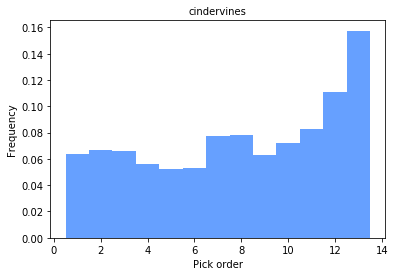

In [16]:
#cardpicks['karn_scion_of_urza']
#cardpicks['karn_scion_of_urza']
#cardpicks['chance_for_glory']

goodCardName = 'cindervines' # Controversial in GRN: ionize, chance_for_glory. Well known: leapfrog, silent_dart

# Histogram of cardpicks
fig, ax = plt.subplots()
n, bins, patches = plt.hist(cardpicks[goodCardName], 13, range=(0.5,13.5), density=True, facecolor=(0.2,0.5,1), alpha=0.75)
ax.set_title(goodCardName, size=10)
plt.xlabel('Pick order')
plt.ylabel('Frequency') 

In [17]:
cardpicksdf = pd.DataFrame({
        'avg' : [np.mean(cardpicks[card]) for card in cardpicks],
        'var' : [np.var(cardpicks[card]) for card in cardpicks],
        'count' : [len(cardpicks[card]) for card in cardpicks],
        'color' : [getCardColor(thisSet[card]) for card in cardpicks],
        'rarity' :[thisSet[card]['rarity'] for card in cardpicks],
        'legendary' : [1 if isLegendary(thisSet[card]) else 0 for card in cardpicks]
    }, list(cardpicks.keys()))
#cardpicksdf.head()

In [18]:
cardpickOndf = pd.DataFrame({
        'avg' : [np.mean(cardpickOn[card]) for card in cardpickOn],
        'var' : [np.var(cardpickOn[card]) for card in cardpickOn],
        'count' : [len(cardpickOn[card]) for card in cardpickOn],
        'color' : [getCardColor(thisSet[card]) for card in cardpickOn],
        'rarity' :[thisSet[card]['rarity'] for card in cardpickOn],
        'legendary' : [1 if isLegendary(thisSet[card]) else 0 for card in cardpickOn]
    }, list(cardpickOn.keys()))

In [28]:
if player=='human':
    cardpicksdf.to_csv('../../data/controversial_cards_data.csv', index_label="name")
    cardpickOndf.to_csv('../../data/controversial_cards_data_onColor.csv', index_label="name")
else:
    cardpicksdf.to_csv('../../data/controversial_cards_data_bot.csv', index_label="name")
    cardpickOndf.to_csv('../../data/controversial_cards_data_onColor_bot.csv', index_label="name")

In [22]:
cardpicksdf.sort_values(by=['var'], ascending=False).head(10)
#cardpicksdf.iloc[0]['rarity'] == 'Common'

,avg,var,count,color,rarity,legendary
kaya_orzhov_usurper,7.561835,18.618517,1504,1,mythic,1
emergency_powers,9.187817,18.339344,985,1,mythic,0
cindervines,8.856627,17.973420,1660,1,rare,0
mirror_march,7.475898,17.096045,1141,5,rare,0
absorb,7.230187,16.507337,1981,1,rare,0
smothering_tithe,7.532508,16.482689,1292,2,rare,0
high_alert,7.058573,16.481829,2578,1,uncommon,0
lavinia_azorius_renegade,9.094844,15.856695,1571,1,rare,1
blood_crypt,7.832180,15.183774,2312,1,rare,0
godless_shrine,7.628521,15.098799,2272,1,rare,0


In [23]:
def getHeights(picks):
    heights = [0 for x in range(16)]
    
    for num in picks:
        heights[num] +=1
        
    return heights

In [24]:
colorkey = ['0', 'M', 'W', 'U', 'B', 'G', 'R']
colorid = ['#9F9F9F', 'DC03FD', '#F3C750', '#0E68AB', '#150B00', '#00733E', '#D3202A']
mplcolors = ['gray', 'mediumvioletred', 'orange', 'dodgerblue', 'black', 'g', 'red']


In [25]:
mplrarity = ['crimson','orange','gray', 'black', 'w']
rarity= ['Mythic Rare', 'Rare', 'Uncommon', 'Common', 'Basic Land']

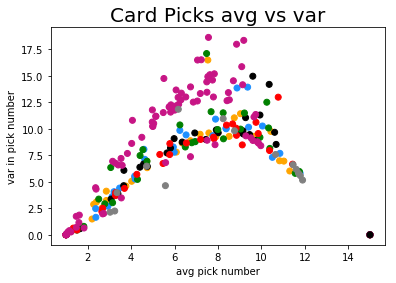

In [26]:
fig, ax = plt.subplots()

scatter = ax.scatter(cardpicksdf['avg'],
                     cardpicksdf['var'],
                     c = [mplcolors[x] for x in cardpicksdf['color']]
                    )

ax.set_title("Card Picks avg vs var", size=20)
plt.xlabel('avg pick number')
plt.ylabel('var in pick number') 

labels = list(cardpicksdf.index)
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)

#plt.savefig('avgvsvar.png')

#mpld3.display()

ValueError: 'mythic' is not in list

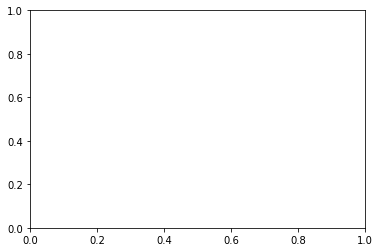

In [27]:
fig, ax = plt.subplots()

scatter = ax.scatter(cardpicksdf['avg'],
                     cardpicksdf['var'],
                     c = [mplrarity[rarity.index(x)] for x in cardpicksdf['rarity']]
                    )

ax.set_title("Card Picks avg vs var by rarity", size=20)
plt.xlabel('avg pick number')
plt.ylabel('var in pick number') 



labels = list(cardpicksdf.index)
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)

#plt.savefig('avgvsvarRarityDom.png')

#mpld3.display()

In [ ]:
fig, ax = plt.subplots()

#The top scatter is for legendary cards. The bottom is non legendary.
#You can comment one out for more clarity

scatter = ax.scatter(cardpicksdf.loc[cardpicksdf['legendary'] == 1]['avg'],
                     cardpicksdf.loc[cardpicksdf['legendary'] == 1]['var'],
                     c = [mplrarity[rarity.index(x)] for x in cardpicksdf['rarity']],
                     marker = 's'
                    )
scatter = ax.scatter(cardpicksdf.loc[cardpicksdf['legendary'] == 0]['avg'],
                     cardpicksdf.loc[cardpicksdf['legendary'] == 0]['var'],
                     c = [mplrarity[rarity.index(x)] for x in cardpicksdf['rarity']],
                     marker = 'o'
                    )

ax.set_title("Card Picks avg vs var by rarity", size=10)
plt.xlabel('avg pick number')
plt.ylabel('var in pick number') 



labels = list(cardpicksdf.index)
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)

plt.savefig('avgvsvarRarityDomNormal.png')

mpld3.display()